# Plot Customization

In [43]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc, classification_report


## 30-day Model

In [ ]:
xgb_model_30d = xgb.XGBClassifier()
xgb_model_30d.load_model('30d_best_model.json')

In [14]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 
train_df, val_df = train_test_split(training_data_imputed_df, test_size=0.2, random_state=1)

X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val_30 = val_df['cdiff_30d_flag']

y_val_30.value_counts()

cdiff_30d_flag
0.0    17027
1.0     1037
Name: count, dtype: int64

## AUROC Curves

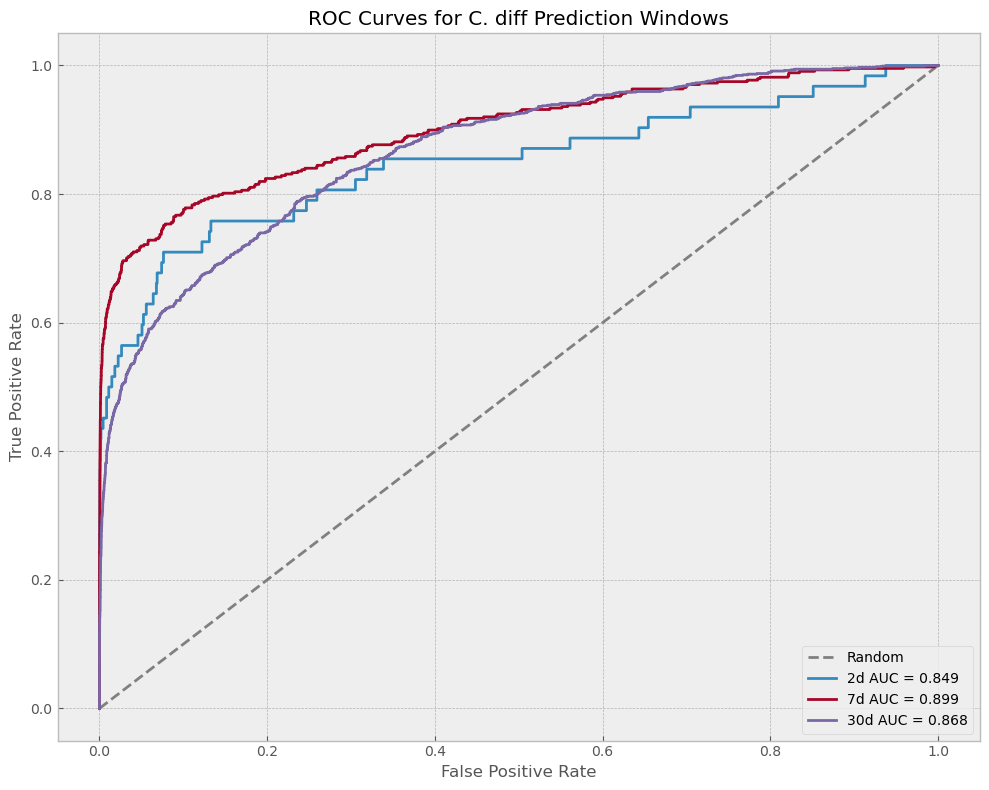

In [104]:
windows = ['2d', '7d', '30d']
plt.figure(figsize=(10, 8))
plt.style.use('bmh')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    y_val_pred = xgb_model.predict(X_val)
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_true, y_val_prob)
    auc_score = roc_auc_score(y_true, y_val_prob)

    plt.step(fpr, tpr, label=f"{window} AUC = {auc_score:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for C. diff Prediction Windows")
    plt.legend(loc="lower right")
    plt.tight_layout()
plt.show()

## AUPRC

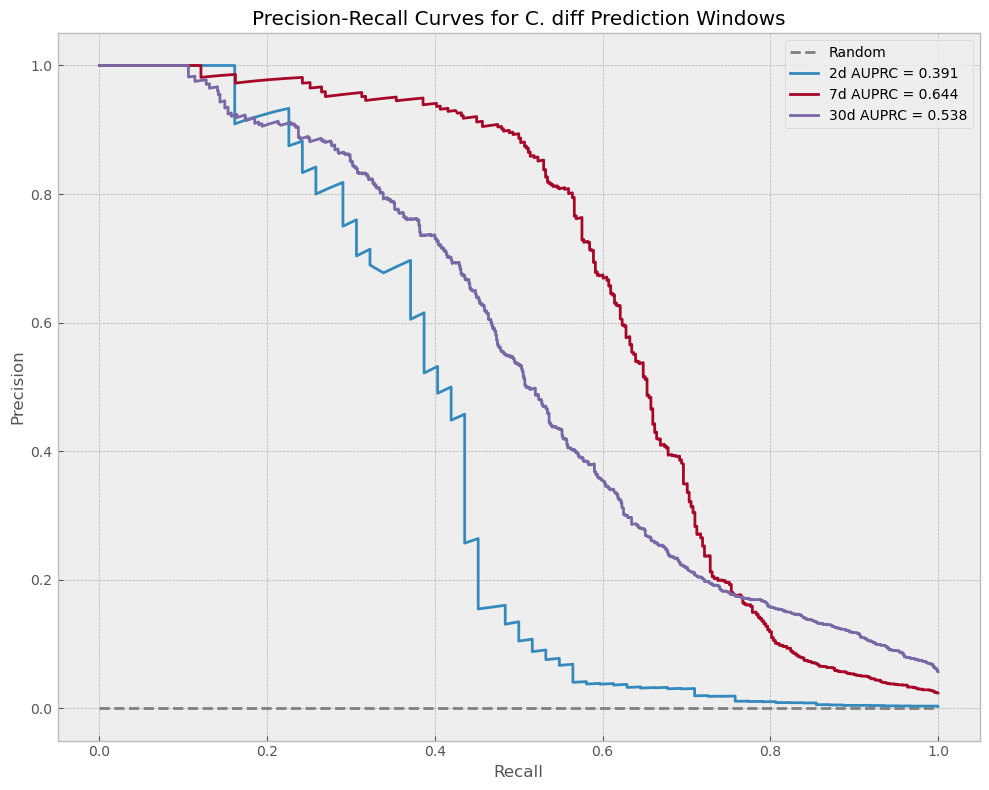

In [105]:
windows = ['2d', '7d', '30d']
plt.figure(figsize=(10, 8))
plt.style.use('bmh')
plt.plot([0, 1], [0, 0], linestyle='--', color='gray', label="Random")
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    y_val_pred = xgb_model.predict(X_val)
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1]  


    precision, recall, thresholds = precision_recall_curve(y_true, y_val_prob)
    auprc_score = average_precision_score(y_true, y_val_prob)

    plt.plot(recall, precision, label=f"{window} AUPRC = {auprc_score:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curves for C. diff Prediction Windows")
    plt.legend(loc="upper right")
    plt.tight_layout()
plt.show()

## Feature Importance

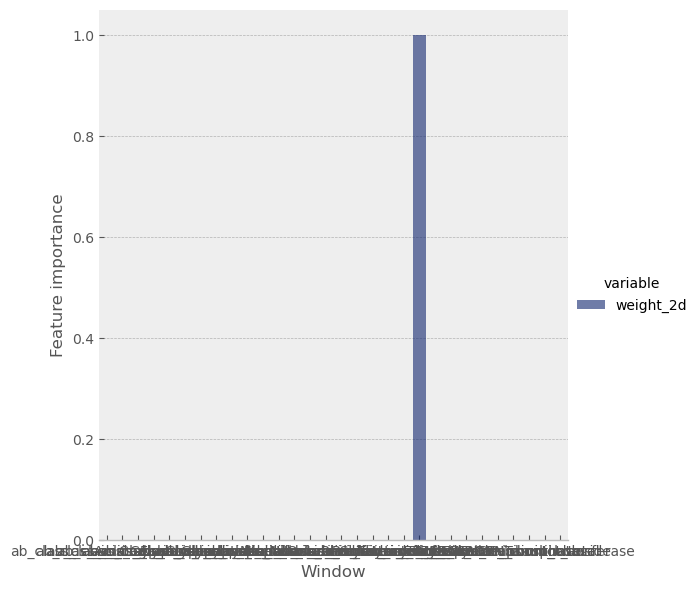

In [129]:
windows = ['2d', '7d', '30d']
feature_importances_df = pd.DataFrame({'feature': xgb_model.feature_names_in_})
# plt.figure(figsize=(10, 7))
# plt.style.use('bmh')
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    window_df = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='weight').items(), columns=['feature', f'weight_{window}']).sort_values([f'weight_{window}']).head(10)

    feature_importances_df = feature_importances_df.merge(window_df, on='feature', how='outer')
feature_importances_long = pd.melt(feature_importances_df, id_vars=['feature'], value_vars=['weight_2d', 'weight_7d', 'weight_30d'])
feature_importances_long = feature_importances_long.head(10 * 3) 
feature_importances_long
g = sns.catplot(
    data=feature_importances_long, kind="bar",
    x="feature", y="value", hue="variable",
     palette="dark", alpha=.6, height=6
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.despine(left=True)
g.set_axis_labels("Window", "Feature importance")
# g.legend.set_title("")

In [130]:
feature_importances_df

,feature,weight_2d,weight_7d,weight_30d
0,ab_class_is_Aminoglycoside,NaN,7.0,NaN
1,ab_class_is_Carbapenem,NaN,NaN,NaN
2,ab_class_is_Cephalosporin,NaN,NaN,1.0
3,ab_class_is_Fluoroquinolone,NaN,NaN,2.0
4,ab_class_is_Glycopeptide,NaN,NaN,NaN
...,...,...,...,...
160,sd_hemoglobin,NaN,NaN,NaN
161,sd_platelets,2.0,NaN,NaN
162,sd_potassium,NaN,NaN,NaN
163,sd_sodium,NaN,NaN,NaN


<Figure size 1200x800 with 0 Axes>

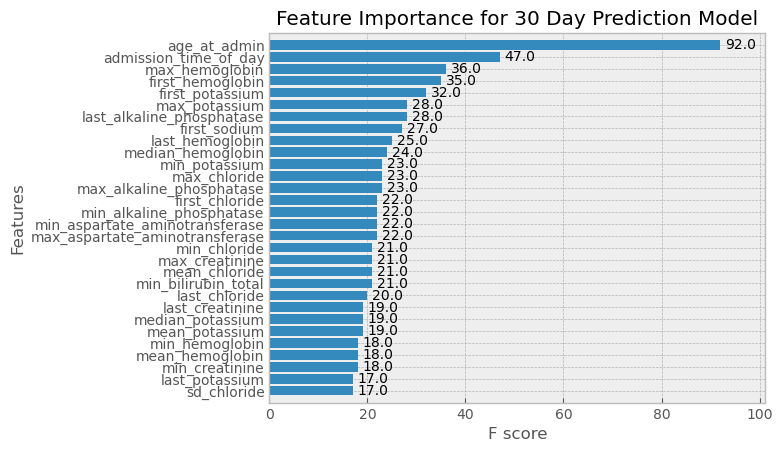

In [66]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model_30d, max_num_features=30, height=0.8)
plt.title('Feature Importance for 30 Day Prediction Model')
plt.show()